<a href="https://colab.research.google.com/github/TanushreeNayak/Trader_behavior_insights/blob/main/Trader_behavior_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q statsmodels scikit-learn matplotlib seaborn gdown

In [ ]:
import os
import io
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

sns.set(style="darkgrid", rc={"figure.figsize": (12,6)})
print("Imports ready. Working directory:", os.getcwd())

Imports ready. Working directory: /content


In [ ]:

from google.colab import files, drive
import gdown

def choose_input():
    print("Options to load data:")
    print( "Mount Google Drive and specify paths.")
    choice = input("Choose : ") or "1"
    return choice

def load_csv_interactive():
    choice = choose_input()
    if choice == "1":
        print("Please upload historical_data.csv and fear_greed_index.csv using the file picker.")
        uploaded = files.upload()
        # try common filenames
        names = list(uploaded.keys())
        print("Uploaded files:", names)
        hist_fn = None; fg_fn = None
        for n in names:
            ln = n.lower()
            if "historic" in ln or "hyper" in ln or "histor" in ln or "trader" in ln:
                hist_fn = n
            if "fear" in ln or "greed" in ln or "fg" in ln:
                fg_fn = n
        # fallback to first two files if not found
        if hist_fn is None and len(names) >= 1:
            hist_fn = names[0]
        if fg_fn is None and len(names) >= 2:
            fg_fn = names[1] if names[1] != hist_fn else (names[0] if names[0]!=hist_fn else names[0])
        hist = pd.read_csv(io.BytesIO(uploaded[hist_fn])) if hist_fn else None
        fg   = pd.read_csv(io.BytesIO(uploaded[fg_fn])) if fg_fn else None
        return hist, fg
    else:
        print("Mounting Google Drive. Provide full paths to the files.")
        drive.mount('/content/drive')
        hist_path = input("Enter full path to historical_data.csv in Drive (/content/historical_data.csv): ").strip()
        fg_path = input("Enter full path to fear_greed_index.csv in Drive (/content/fear_greed_index.csv): ").strip()
        return pd.read_csv(hist_path), pd.read_csv(fg_path)

# Run interactive loader
hist_df, fg_df = load_csv_interactive()
print("Loaded data shapes -> historical:", None if hist_df is None else hist_df.shape,
      ", fear_greed:", None if fg_df is None else fg_df.shape)


Options to load data:
Mount Google Drive and specify paths.
Choose : 1
Please upload historical_data.csv and fear_greed_index.csv using the file picker.


Saving historical_data.csv to historical_data (1).csv
Uploaded files: ['historical_data (1).csv']
Loaded data shapes -> historical: (211224, 16) , fear_greed: None


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [ ]:

hist_path = '/content/historical_data.csv'
fg_path = '/content/fear_greed_index.csv'


hist_df = pd.read_csv(hist_path)
fg_df = pd.read_csv(fg_path)

# Confirm load success
print("Historical Data loaded:", hist_df.shape)
print("Fear/Greed Data loaded:", fg_df.shape)


Historical Data loaded: (211224, 16)
Fear/Greed Data loaded: (2644, 4)


In [ ]:
def show_basic(df, name, n=5):
    print(f"--- {name} shape:", df.shape)
    display(df.head(n))
    print("\nInfo:")
    display(df.info())
    print("\nSummary:")
    display(df.describe(include='all').T)
show_basic(hist_df, "Historical Data")
show_basic(fg_df, "Fear/Greed Data")


--- Historical Data shape: (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), f

None


Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Account,211224,32,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Coin,211224,246,HYPE,68005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Execution Price,211224.0,NaN,NaN,NaN,11414.72335,29447.654868,0.000005,4.8547,18.28,101.58,109004.0
Size Tokens,211224.0,NaN,NaN,NaN,4623.364979,104272.88953,0.000001,2.94,32.0,187.9025,15822438.0
Size USD,211224.0,NaN,NaN,NaN,5639.45121,36575.138546,0.0,193.79,597.045,2058.96,3921430.72
Side,211224,2,SELL,108528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp IST,211224,27977,14-02-2025 00:31,441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Start Position,211224.0,NaN,NaN,NaN,-29946.248839,673807.423736,-14334629.0,-376.231075,84.727932,9337.2775,30509482.0
Direction,211224,12,Open Long,49895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Closed PnL,211224.0,NaN,NaN,NaN,48.749001,919.164828,-117990.1041,0.0,0.0,5.792797,135329.0901


--- Fear/Greed Data shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


None


Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
timestamp,2644.0,NaN,NaN,NaN,1631898885.022693,65979674.322218,1517463000.0,1574811000.0,1631899800.0,1688988600.0,1746163800.0
value,2644.0,NaN,NaN,NaN,46.981089,21.82768,5.0,28.0,46.0,66.0,95.0
classification,2644,5,Fear,781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,2644,2644,2025-05-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("\nHistorical columns:\n", hist_df.columns)
print("\nFear/Greed columns:\n", fg_df.columns)



Historical columns:
 Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

Fear/Greed columns:
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [ ]:
# --- Clean Historical Data ---
hist_df.columns = hist_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert time column to datetime
time_col = [c for c in hist_df.columns if 'time' in c][0]  # auto-detect 'time' column
hist_df[time_col] = pd.to_datetime(hist_df[time_col], errors='coerce')

# Extract date only for grouping
hist_df['date'] = hist_df[time_col].dt.date

# Ensure closedPnL column exists (auto-detect similar names)
pnl_col = [c for c in hist_df.columns if 'pnl' in c.lower()][0]
hist_df['closed_pnl'] = pd.to_numeric(hist_df[pnl_col], errors='coerce')

print("✅ Cleaned Historical Data")
display(hist_df.head())


✅ Cleaned Historical Data


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12


In [ ]:
fg_df.columns = fg_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Detect date and sentiment/score column
date_col = [c for c in fg_df.columns if 'date' in c][0]
fg_df[date_col] = pd.to_datetime(fg_df[date_col], errors='coerce')
fg_df['date'] = fg_df[date_col].dt.date

# If sentiment is categorical (Fear, Greed) → map to numeric score
if 'classification' in fg_df.columns:
    fg_df['sentiment_score'] = fg_df['classification'].map({
        'Extreme Fear': 0.1,
        'Fear': 0.3,
        'Neutral': 0.5,
        'Greed': 0.7,
        'Extreme Greed': 0.9
    })
else:
    # Otherwise normalize existing numeric score
    num_col = [c for c in fg_df.columns if c not in ['date']][0]
    fg_df['sentiment_score'] = (fg_df[num_col] - fg_df[num_col].min()) / (fg_df[num_col].max() - fg_df[num_col].min())

print("✅ Cleaned Fear/Greed Data")
display(fg_df.head())


✅ Cleaned Fear/Greed Data


,timestamp,value,classification,date,sentiment_score
0,1517463000,30,Fear,2018-02-01,0.3
1,1517549400,15,Extreme Fear,2018-02-02,0.1
2,1517635800,40,Fear,2018-02-03,0.3
3,1517722200,24,Extreme Fear,2018-02-04,0.1
4,1517808600,11,Extreme Fear,2018-02-05,0.1


In [ ]:
# Aggregate daily trader performance
daily_pnl = hist_df.groupby('date')['closed_pnl'].agg(['mean', 'sum', 'median', 'count']).reset_index()
daily_pnl.rename(columns={'mean':'avg_pnl', 'sum':'total_pnl', 'count':'num_trades'}, inplace=True)

# Merge with sentiment
merged_df = pd.merge(daily_pnl, fg_df[['date', 'sentiment_score']], on='date', how='inner')

print("✅ Merged Dataset:")
display(merged_df.head())
print(merged_df.describe())


✅ Merged Dataset:


,date,avg_pnl,total_pnl,median,num_trades,sentiment_score
0,2023-01-05,0.000000,0.000000,0.00000,3,0.3
1,2023-05-12,0.000000,0.000000,0.00000,9,0.5
2,2024-01-01,-7.196192,-129.531460,0.00000,18,0.7
3,2024-01-02,0.000000,0.000000,0.00000,6,0.7
4,2024-01-03,60.176945,8244.241409,27.04384,137,0.7


          avg_pnl      total_pnl      median   num_trades  sentiment_score
count  158.000000     158.000000  158.000000   158.000000       158.000000
mean    39.468240   22941.825756    4.553845   226.987342         0.617722
std    136.730354   90851.081811   21.132622   473.917217         0.244303
min   -965.921267 -122672.000883  -37.697891     1.000000         0.100000
25%      0.000000       0.000000    0.000000    16.000000         0.300000
50%     12.482105     460.306586    0.000000    41.000000         0.700000
75%     63.579341    5172.042387    0.000000   164.250000         0.900000
max    918.156160  616413.032233  232.802979  2512.000000         0.900000


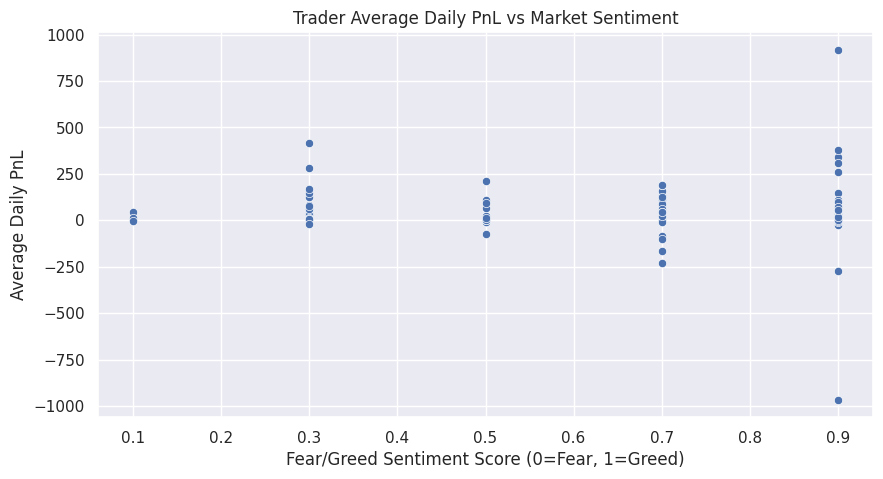


Correlation Matrix:


,sentiment_score,avg_pnl,total_pnl
sentiment_score,1.000000,-0.007681,-0.057291
avg_pnl,-0.007681,1.000000,0.550993
total_pnl,-0.057291,0.550993,1.000000


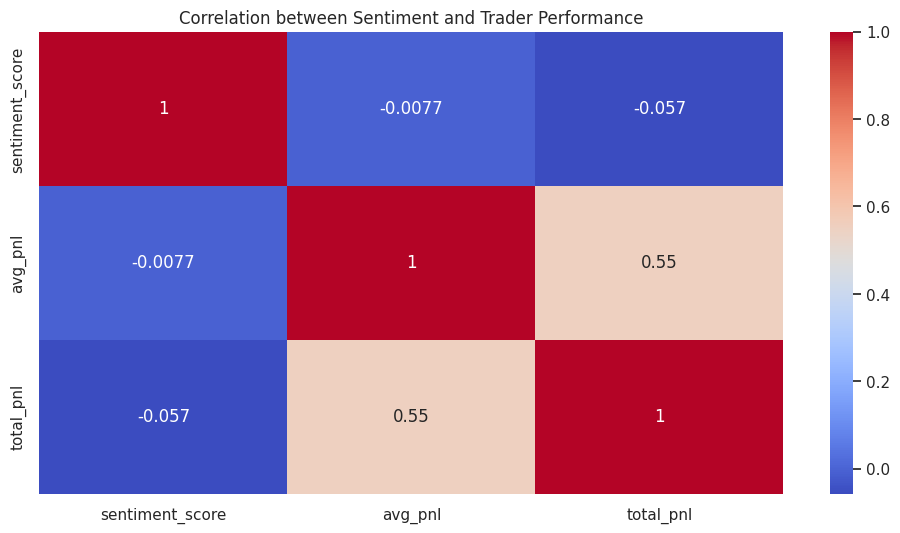

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=merged_df, x='sentiment_score', y='avg_pnl')
plt.title("Trader Average Daily PnL vs Market Sentiment")
plt.xlabel("Fear/Greed Sentiment Score (0=Fear, 1=Greed)")
plt.ylabel("Average Daily PnL")
plt.grid(True)
plt.show()

# Correlation
corr = merged_df[['sentiment_score','avg_pnl','total_pnl']].corr()
print("\nCorrelation Matrix:")
display(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Sentiment and Trader Performance")
plt.show()
